## Homework 3 - Crowd Image Classification


In [1]:
'''
******************************************************************************
  CSE-512-Machine Learning HW3 Question 2
  Name: Rishabh Goel
  SBU Id : 112714848
  Email Id: rishabh.goel@stonybrook.edu
*******************************************************************************
'''

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import math
from math import exp
from sklearn.metrics import confusion_matrix

import warnings  
warnings.filterwarnings('ignore')

**Loading data**

In [27]:
# train data
train = pd.read_pickle('/kaggle/input/cse512hw3/Train_Features.pkl')
# validation data
val = pd.read_pickle('/kaggle/input/cse512hw3/Val_Features.pkl')
# test data
test = pd.read_pickle('/kaggle/input/cse512hw3/Test_Features.pkl')
# train labels
train_lbl_data = pd.read_csv('/kaggle/input/cse512hw3/Train_Labels.csv')
# validation labels
val_lbl_data = pd.read_csv('/kaggle/input/cse512hw3/Val_Labels.csv')

In [28]:
train_lbl={}
for index, row in train_lbl_data.iterrows():
    train_lbl[row['Id']] = row['Category']
val_lbl={}
for index, row in val_lbl_data.iterrows():
    val_lbl[row['Id']] = row['Category']

In [29]:
# combined train and validation data
train_val = {**train, **val}

# combined train and validation labels
train_val_lbl = {**train_lbl, **val_lbl}

**Normalization functions**

In [30]:
def sum_normalize(data):
    factor = 1.0/sum(data.values())
    for k in data:
        data[k] = data[k]*factor
    return data

def l1_normalize(data):
    l1=0
    for n in list(data.values()):
        l1=l1+abs(n)
    for k in data:
        data[k] = data[k]/l1
    return data

def l2_normalize(data):
    l2=0
    for n in list(data.values()):
        l2=l2+(n*n)
    l2=np.sqrt(l2)
    for k in data:
        data[k] = data[k]/l2
    return data

def min_max_normalize(data):
    for k in data:
         data[k] = (data[k]-min(data[k]))/(max(data[k])-min(data[k]))
    return data

In [31]:
train_val = sum_normalize(train_val)
train = sum_normalize(train)
val = sum_normalize(val)
test = sum_normalize(test)

In [32]:
train_val = min_max_normalize(train_val)
train = min_max_normalize(train)
val = min_max_normalize(val)
test = min_max_normalize(test)

## 2.3 Implement Logistic Regression with SGD

In [33]:
no_classes = 4

In [34]:
# Probability of X[idx] belonging to class c
def prob(c, theta, k, idx, X_bar):
    num=1
    
    #P(Y=k|X;θ) = 1/(1+ ∑ⱼ₌₁ₜₒₖ₋₁ exp(θᵢᵀX̄)) for j = 1, · · · , k − 1
    if c==k-1:
        den =  1
        for t in range(0,k-1):
            den = den + exp(np.dot(theta[t].T,list(X_bar.values())[idx]))
    #P(Y=c|X;θ) = exp(θᵢᵀX̄)/(1+ ∑ⱼ₌₁ₜₒₖ₋₁ exp(θᵢᵀX̄)) for j = 1, · · · , k − 1
    else:
        div =  np.dot(theta[c].T,list(X_bar.values())[idx])
        den =  exp(-np.dot(theta[c].T,list(X_bar.values())[idx]))
        for t in range(0,k-1):
            den = den + exp(np.dot(theta[t].T,list(X_bar.values())[idx])-div)
    return (num/den)

In [35]:
'''Loss function L(θ) = (−1/n)∑ᵢ₌₁ₜₒₙlog(P(Yᵢ|X̄ᵢ;θ)).'''
def L(theta,X):
    sum1=0
    for i in range(0,len(X)):
        for c in range(0,4):
            sum1=sum1+np.log(prob(c,theta,4,i,X))
    return (-sum1/(len(X)))

In [36]:
def accuracy(coef):
    correct_predict=0
    for i in range(0,len(val)):
        max_prob=0
        pred_class=0
        for c in range(0,4):
            p = prob(c,coef,4,i,val)
            if(p>max_prob):
                max_prob=p
                pred_class=c+1
        correct_predict = correct_predict + (val_lbl[list(val.keys())[i]]==pred_class)
    return (correct_predict/len(val))

In [37]:
# Yield successive n-sized chunks from l.
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# Estimate logistic regression coefficients using stochastic gradient descent
def coefficients_sgd(X, Y, m, n0, n1, max_epoch, delta):
    no_feat=len(list(X.values())[0])
    #for key in X.keys():
    #    X[key] = np.append(X[key],1)
    theta_old = np.ones((no_classes,no_feat))   # Initializing θᵒˡᵈ
    theta_new = np.ones((no_classes,no_feat))   # Initializing θⁿᵉʷ
    L_df = pd.DataFrame(columns={'epoch','L_theta'})  # dataframe to store results like epoch taken and final value of loss function
    X_list = list(X.values())
    epoch_taken=0
    for epoch in range(1,max_epoch+1):    # 2. for epoch = 1, 2, ..., max epoch do
        epoch_taken = epoch
        theta_old = theta_new.copy()  # Updating theta
        n = n0/(n1+epoch)    # 3. η ← η0/(η1 + epoch)
        permute = np.random.permutation(len(X))   # 4. (i1, ..., in) = permute(1, ..., n)
        batches = list(chunks(permute,m))  # 5. Divide (i1, ..., in) into batches of size m or m + 1
        
        for batch in batches:     # 6. for each batch B do
            for c in range(0,no_classes):
                batch_sum=np.zeros((1,no_feat))  # Initializing batch sum
                for idx in batch:
                    '''∂log(P(Yᵢ|X̄ᵢ; θ))/∂θ𝒸 = (δ(c=Yᵢ) − P(c|X̄ᵢ;θ))X̄ᵢ'''
                    gradient = np.dot(((Y[list(X.keys())[idx]]-1==c)-prob(c,theta_new,no_classes,idx,X)),X_list[idx])
                    batch_sum = batch_sum + gradient
                theta_new[c] = theta_new[c] + n*(batch_sum/len(batch))      # 7: Update θ using Eqs. (5) and (7)
        
        L_df = L_df.append({'epoch' : epoch, 'L_theta' : L(theta_new,X), 'accuracy' : accuracy(theta_new)},ignore_index=True)
        if L(theta_new,X) > (1-delta)*L(theta_old,X):   # 8. Break if L(θⁿᵉʷ) > (1 − δ)L(θᵒˡᵈ) // not much progress, terminate
            break
    return (theta_old,epoch_taken,L_df)   # 9. Outputs: θ.

**2.3.1** Run your implementation on the provided training data with max epoch = 1000, m =
16, η0 = 0.1, η1 = 1, δ = 0.00001.

In [ ]:
# Run this the first time, then comment it and just load results from the next cell.
# Calculate coefficients
m = 16  
n0 = 0.1   
n1 = 1.0
max_epoch = 1000
delta = 0.00001
(coef,epoch_taken,train_L_df) = coefficients_sgd(train, train_lbl, m, n0, n1, max_epoch, delta)
train_L_df.to_csv('Q1.csv',index=False)

(a) Report the number of epochs that your algorithm takes before exiting <br>
(b) Plot the curve showing L(θ) as a function of epoch. <br>
(c) What is the final value of L(θ) after the optimization?

In [38]:
# Use results from previously trained data
train_L_df = pd.read_csv('/kaggle/input/output/Q1.csv')

No of epoch taken 34.0
Final value of L(θ) after the optimization 8.179215080705807


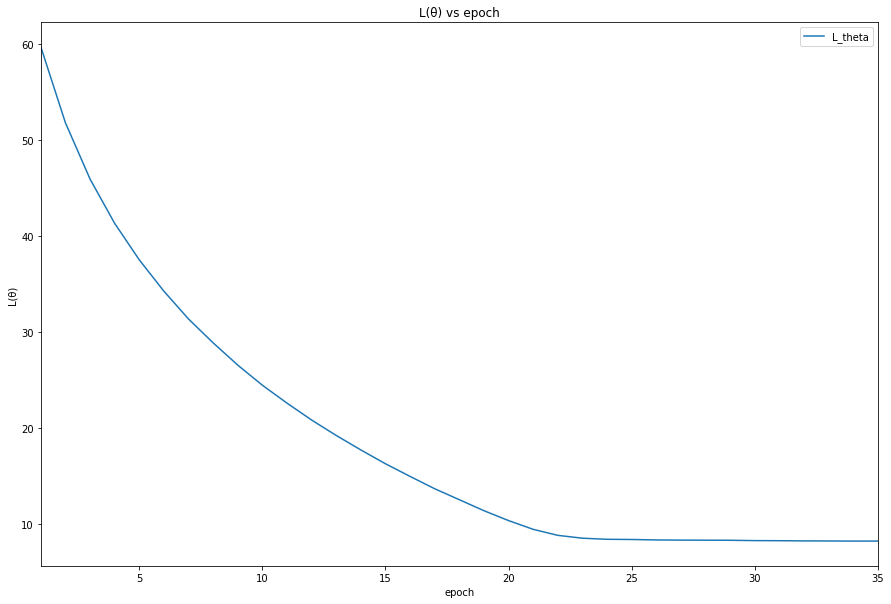

In [39]:
print(f'No of epoch taken {train_L_df.iloc[-2]["epoch"]}')
print(f'Final value of L(θ) after the optimization {train_L_df.iloc[-2]["L_theta"]}')
ax = train_L_df.plot.line(x='epoch', y='L_theta')
ax.set_xlabel("epoch")
ax.set_ylabel("L(θ)")
ax.set_title("L(θ) vs epoch")
#plt.xscale('log',basex=10) 
plt.rcParams['figure.figsize'] = [15, 10]

**2.3.2** Keep m = 16, δ = 0.00001, experiment with different values of η0 and η1. Can you find a
pair of parameters (η0, η1) that leads to faster convergence?

In [ ]:
# Run this the first time, then comment it and just load results from the next cell.
m = 16      
max_epoch = 1000
delta = 0.00001

# Trying different combinations of n0 and n1
n0s = np.arange(0.1, 1.0, 0.2)
n1s = np.arange(0.1, 1.0, 0.2)

optimal_df = pd.DataFrame(columns={'n0','n1','epoch','L_theta'})

for n0 in n0s:
    for n1 in n1s:
        (coef,epoch_taken,L_df) = coefficients_sgd(train, train_lbl, m, n0, n1, max_epoch, delta)
        optimal_df = optimal_df.append({'n0' : n0 , 'n1' : n1, 'epoch' : epoch_taken, 'L_theta' : L(coef,train)},ignore_index=True)
optimal_df.to_csv('Q2.csv',index=False)

(a) Report the values of (η0, η1). How many epochs does it take? What is the final value of L(θ)? <br>
(b) Plot the curve showing L(θ) as a function of epoch.

In [40]:
# Use results from previously trained data
combo_L_df = pd.read_csv('/kaggle/input/output/Q2.csv')
combo_L_df

,n0,n1,epoch,L_theta
0,0.9,0.5,2,7.834536
1,0.7,0.3,3,6.696355
2,0.7,0.5,3,6.698894
3,0.7,0.1,3,6.708297
4,0.7,0.7,4,6.568831
5,0.7,0.9,4,6.593851
6,0.5,0.1,4,6.653025
7,0.9,0.3,4,6.654438
8,0.9,0.1,5,6.784653
9,0.3,0.5,5,7.216769


In [ ]:
# Run this the first time, then comment it and just load results from the next cell.
# Calculate coefficients
m = 16      
n0 = 0.9
n1 = 0.5
max_epoch = 1000
delta = 0.00001
(coef,epoch_taken,fast_L_df) = coefficients_sgd(train, train_lbl, m, n0, n1, max_epoch, delta)
fast_L_df.to_csv('Q2a.csv',index=False)

In [3]:
# Use results from previously trained data
fast_L_df = pd.read_csv('/kaggle/input/output/Q2a.csv')

Convergence is faster for n0 = 0.9 and n1=0.5
No of epoch taken 3.0
Final value of L(θ) after the optimization 6.8133311822332265


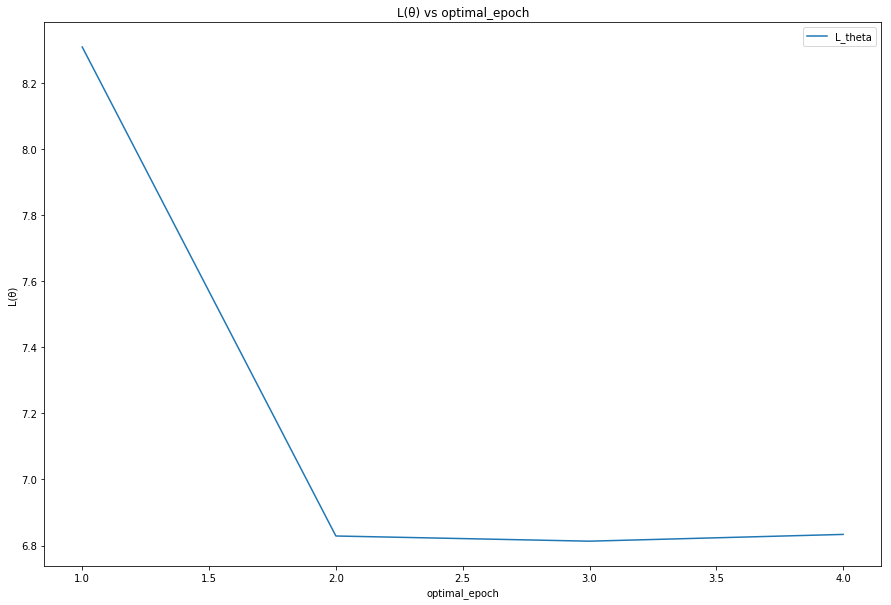

In [5]:
print(f'Convergence is faster for n0 = 0.9 and n1=0.5')
print(f'No of epoch taken {fast_L_df.iloc[-2]["epoch"]}')
print(f'Final value of L(θ) after the optimization {fast_L_df.iloc[-2]["L_theta"]}')
ax = fast_L_df.plot.line(x='epoch', y='L_theta')
ax.set_xlabel("optimal_epoch")
ax.set_ylabel("L(θ)")
ax.set_title("L(θ) vs optimal_epoch")
#plt.xscale('log',basex=10) 
plt.rcParams['figure.figsize'] = [15, 10]

**2.3.3** Evaluate the performance on validation data.

In [46]:
# Run this the first time, then comment it and just load results from the next cell.
# Calculate coefficients
m = 16      
n0 = 0.9
n1 = 0.5
max_epoch = 1000
delta = 0.00001
(coef_t,epoch_taken_t,train_L_df) = coefficients_sgd(train , train_lbl, m, n0, n1, max_epoch, delta)
(coef_v,epoch_taken_v,val_L_df)   = coefficients_sgd(val   , val_lbl,   m, n0, n1, max_epoch, delta)
val_L_df.to_csv('Q3_val.csv',index=False)
train_L_df.to_csv('Q3_train.csv',index=False)

In [43]:
# Use results from previously trained data
val_L_df = pd.read_csv('/kaggle/input/output/Q3_val.csv')
train_L_df = pd.read_csv('/kaggle/input/output/Q3_train.csv')

(a) Plot L(θ) as a function of epoch. On the same plot, show two curves, one for training and one
for validation data.

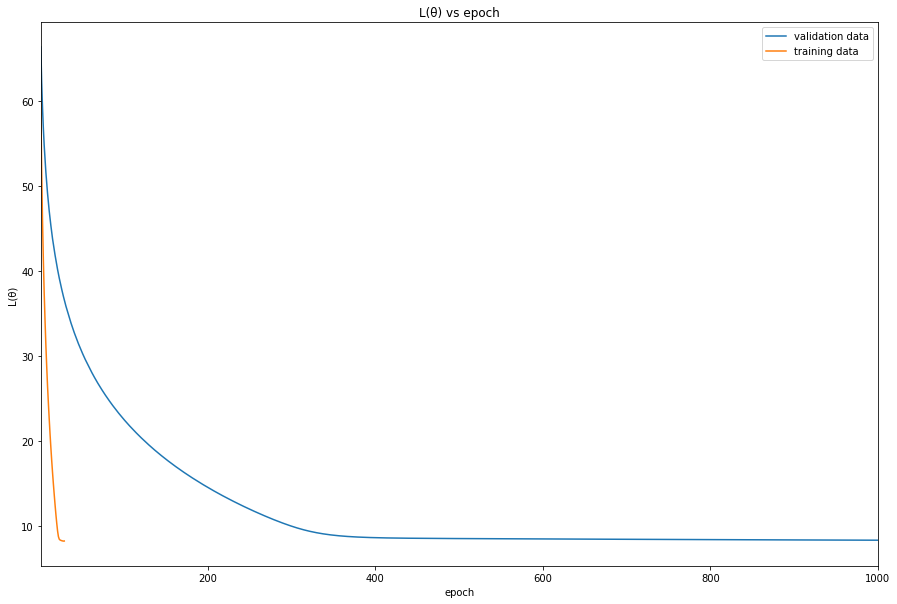

In [44]:
ax = val_L_df.plot.line(x='epoch', y='L_theta',label='validation data')
train_L_df.plot.line(x = 'epoch' , y='L_theta', label = 'training data',ax=ax)
ax.set_xlabel("epoch")
ax.set_ylabel("L(θ)")
ax.set_title("L(θ) vs epoch") 
plt.rcParams['figure.figsize'] = [15, 10]

**The above graph is obtained by training on train data and validation data respectively.**

(b) Plot the accuracy as a function of epoch. On the same plot, show two curves, one for training
and one for validation data.

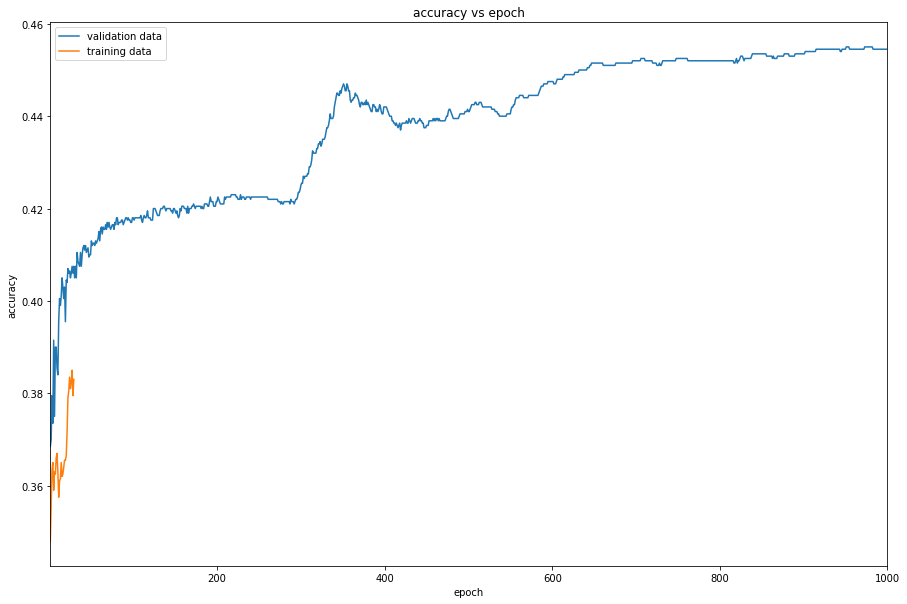

In [45]:
ax = val_L_df.plot.line(x='epoch', y='accuracy',label='validation data')
train_L_df.plot.line(x = 'epoch' , y='accuracy', label = 'training data',ax=ax)
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs epoch") 
plt.rcParams['figure.figsize'] = [15, 10]

**The above graph is obtained by training on train data and validation data respectively, and then testing on validation data.**

**2.3.4** With the learned classifier:
(a) Report the confusion matrices on the validation and the training data.


In [47]:
y_true=[]
y_pred=[]
classes=[1,2,3,4]
for i in range(0,len(val)):
    max_prob=0
    max_class=0
    for c in range(0,4):
        p = prob(c,coef_t,4,i,val)
        if(p>max_prob):
            max_prob=p
            max_class=c+1
    y_true.append(val_lbl[list(val.keys())[i]])
    y_pred.append(max_class)
    
print(confusion_matrix(y_true, y_pred, labels=[1,2,3,4]))

[[179  96  19  22]
 [118 394  52  96]
 [ 41 227  68 102]
 [ 46 181  91 268]]


**We obtain the above confusion matrix after training on train data and evaluating on val data**

In [48]:
y_true=[]
y_pred=[]
classes=[1,2,3,4]
for i in range(0,len(val)):
    max_prob=0
    max_class=0
    for c in range(0,4):
        p = prob(c,coef_v,4,i,val)
        if(p>max_prob):
            max_prob=p
            max_class=c+1
    y_true.append(val_lbl[list(val.keys())[i]])
    y_pred.append(max_class)
    
print(confusion_matrix(y_true, y_pred, labels=[1,2,3,4]))

[[175 108  17  16]
 [102 385  90  83]
 [ 32 146 157 103]
 [ 37 116 109 324]]


**We obtain the above confusion matrix after training on val data and evaluating on val data** <br>
We observe that the no of correctly predicted classes (the ones on the diagonal) are more here since it was trained and evaluated on the same data.

**2.4 Submit the result in Kaggle** <br>
Run your classifier on the test data and submit the result file on Kaggle (https://www.kaggle.com/c/cse512hw3). Report the best accuracy you obtain on the test data, as returned by
the Kaggle website

In [51]:
from math import exp 
# Calculate coefficients
m = 16      
n0 = 0.9
n1 = 0.5
max_epoch = 1000
delta = 0.00001
(coef,epoch_taken,L_df) = coefficients_sgd(train_val, train_val_lbl, m, n0, n1, max_epoch, delta)

In [52]:
result = pd.DataFrame(columns = {'Id','Category'})
for i in range(0,len(test)):
    max_prob=0
    max_class=0
    for c in range(0,4):
        p = prob(c,coef,4,i,test)
        if(p>max_prob):
            max_prob=p
            max_class=c+1
    result = result.append({'Id' : list(test.keys())[i], 'Category' : max_class},ignore_index=True)
result.to_csv('results.csv')
result

,Category,Id
0,2,26-1.jpg
1,2,117-3.jpg
2,4,198-10.jpg
3,2,131-9.jpg
4,1,193-9.jpg
...,...,...
1995,3,137-2.jpg
1996,4,62-10.jpg
1997,4,150-10.jpg
1998,4,184-6.jpg


**Final results**
* I have used both training and validation data to train my model. <br>
* I used minmax normalization to normalize the merged data. <br>
* I am also using learning rate values obtained from part 2, to achieve faster convergence. <br>
* I modified the breaking condition of convergence by making it less strict.
* The best accuracy I have received from Kaggle website is around 43.50 %.


**Failed attempts:**
* I tried adding regularization to loss function, but couldn't achieve better performance. It wasn't worst too, but approximately the same.<br>
* I tried varying the learning rate after every epoch , in addition to the formula given in pseudo code, but no significant improvements there too. <br>
* I tried other types of normalization too, but found minmax to be giving the best performance.
* I played around with batch size, but again, not much improvement.